# ML_12 Временные ряды

## 3. Тренд, сезонность, шум. Инструменты для декомпозиции временного ряда

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("data/AirPassengers.csv", index_col='Month', parse_dates=['Month'])
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


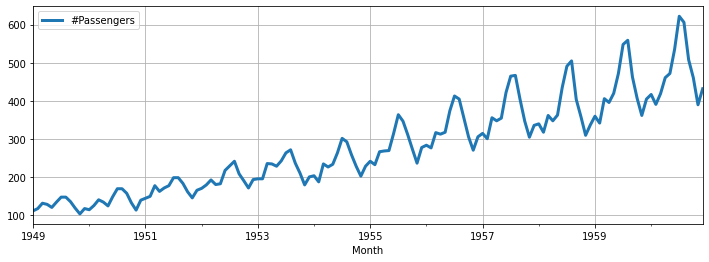

In [8]:
df.plot(
    kind='line',
    figsize=(12, 4),
    grid = True,
    lw=3
);

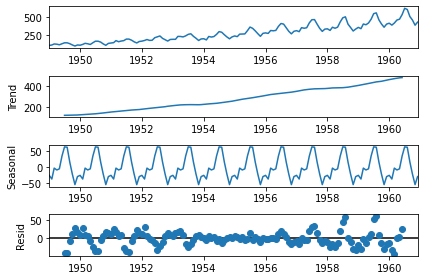

In [9]:
#импортируем библиотеку 
from statsmodels.tsa.seasonal import seasonal_decompose
#производим декомпозицию временного ряда 
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show();

##  4. Экспоненциальное сглаживание

In [10]:
def exp_smth(x_t, a, s_t_1):
    return a * x_t + (1 - a) * s_t_1

data = np.array([15, 20, 25, 30, 25, 27])
a = 0.7
s = np.zeros(7)
s[0] = data[0]

for t, x_t in enumerate(data[1:]):
    s[t] = exp_smth(x_t, a, s[t - 1])

print(s)

[14.     21.7    27.51   25.753  26.6259  0.      0.    ]


Для совершения предсказания методом простого экспоненциального сглаживания воспользуемся методом SimpleExpSmoothing из statsmodels.tsa.api. 

In [11]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(data)

alpha = 0.7

model = ses.fit(smoothing_level = alpha, optimized = False)

forecast = model.forecast(1)

print(forecast)

[26.66235]


## 5. Стационарность

### СТАТИСТИЧЕСКИЕ ТЕСТЫ НА PYTHON

расширенный тест Дики — Фуллера

In [17]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

df = pd.read_csv(
	"data/daily-total-female-births.csv", 
    header=0, 
    index_col=0
).squeeze("columns")

result = adfuller(df.values)

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")

for key, value in result[4].items():
	print(f"\t{key}: {value:.3f}")

ADF Statistic: -4.808291253559767
p-value: 5.243412990149787e-05
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


ЧТО ДЕЛАТЬ, ЕСЛИ РЯД НЕСТАЦИОНАРНЫЙ?

In [15]:
# Для определения порядка интегрированного ряда необходимо сделать следующее:

# Получить новый ряд посредством взятия разности (применяем к необходимому датафрейму):
df_diff_1 = df.diff().dropna()
# Провести для нового ряда тест на стационарность (например, тест Дики — Фуллера):
test1 = adfuller(df_diff_1)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')
# Если полученный ряд нестационарен, можно провести эту процедуру ещё раз, 
# то есть ещё раз дифференцировать разность ряда, полученную на предыдущем этапе.

adf:  -12.625178633871338
p-value:  1.5472400091970336e-23
Critical values:  {'1%': -3.44880082033912, '5%': -2.869670179576637, '10%': -2.5711012838861036}
ряд стационарен


## 6. Автокорреляция

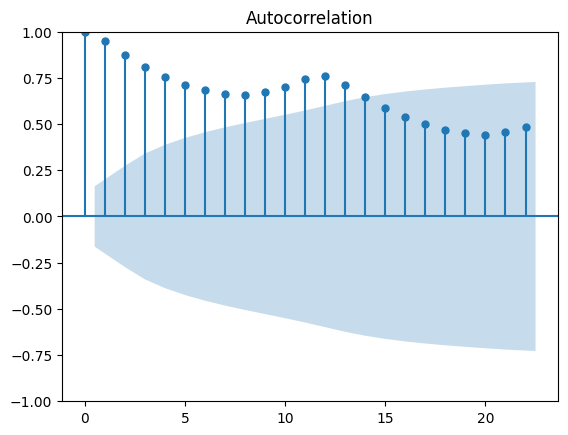

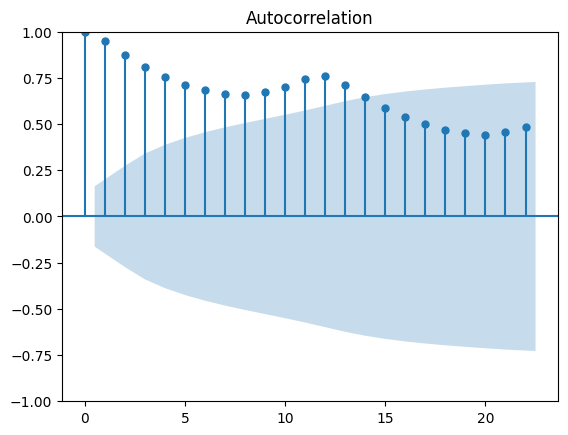

In [22]:
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline
plt.style.use('default')

df = pd.read_csv("data/AirPassengers.csv", index_col='Month', parse_dates=['Month'])
plot_acf(df)

## 7. Авторегрессия

Применим авторегрессионную модель к датасету по производству возобновляемой энергии в Германии. Набор данных включает общую информацию о потреблении электроэнергии в стране, а также о производстве ветровой и солнечной энергии за 2006–2017 годы.

В качестве примера построим предсказание объёма потребления электроэнергии на три месяца (возьмём последние 100 дней).

In [23]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
df = pd.read_csv(url, sep=",")

При использовании статистических моделей временные ряды нельзя делить на обучающую и тестовую выборки случайным образом. Так как нам важно сохранять последовательность, разделим данные на обучающую и тестовую выборки упорядоченно, то есть возьмём в качестве тестовой выборки последние 100 значений. Остальные данные будем использовать для обучения.

In [24]:
train_data = df['Consumption'][:len(df)-100]
test_data = df['Consumption'][len(df)-100:]

In [25]:
# Инициализируем и обучим модель. 
# Возьмём lags=8 (AR(8)) — на практике же будем определять это значение по графику частичной автокорреляции:
ar_model = AutoReg(train_data, lags=8).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:            Consumption   No. Observations:                 4283
Model:                     AutoReg(8)   Log Likelihood              -24231.812
Method:               Conditional MLE   S.D. of innovations             70.058
Date:                Tue, 28 Feb 2023   AIC                          48483.625
Time:                        22:01:17   BIC                          48547.230
Sample:                             8   HQIC                         48506.095
                                 4283                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            121.2792     14.444      8.397      0.000      92.969     149.589
Consumption.L1     0.6393      0.013     47.751      0.000       0.613       0.666
Consumption.L2    -0.0966      0.011

In [26]:
# Сделаем предсказание. Метод predict требует два обязательных параметра — метки начала и окончания предсказания. 
# Метка начала предсказания будет равна количеству данных в обучающей выборке, 
# так как нас интересует прогноз со следующего дня. Метка окончания в нашем случае будет равна len(train_data)+100, 
# что эквивалентно len(df)-1, так как len(df) = len(train_data) + len(test_data).

pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)

## 8. Итоговая практика

In [28]:
df = pd.read_csv("data/tovar_moving.csv",  index_col=['date'], parse_dates=['date'], dayfirst=True) # считываем датасет
df.head() 

,qty
date,
2009-12-25,72314.0
2009-12-26,66586.0
2009-12-27,125199.0
2009-12-28,91544.0
2009-12-29,76995.0


In [32]:
# 1. Отложите в test последнее значение временного ряда.
test = df.iloc[-1]
test
train = df.iloc[:-1]

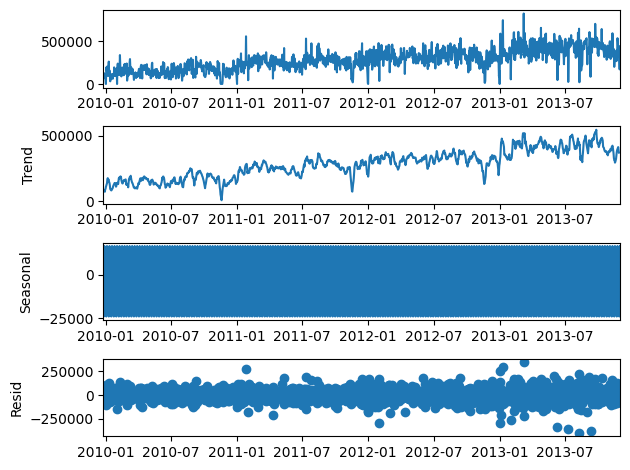

In [30]:
# 2. Проанализируйте временной ряд на наличие тренда и сезонности.
#импортируем библиотеку 
from statsmodels.tsa.seasonal import seasonal_decompose
#производим декомпозицию временного ряда 
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show();

In [44]:
# 3. Постройте прогноз на одно последнее значение с помощью экспоненциального сглаживания (=0.7). 
# Сравните результат с фактическим значением, которое вы отложили вначале.

from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(train)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
forecast = model.forecast(1)
exp_pred = forecast[0]
print('предсказано:',forecast)
print("истина:", test)

предсказано: 2013-12-02    225015.522647
Freq: D, dtype: float64
истина: qty    423846.0
Name: 2013-12-02 00:00:00, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [37]:
# 4. Проверьте ряд на стационарность, определите порядок интегрирования.
import statsmodels.api as sm

def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(df)

adf:  -2.237975149399059
p-value:  0.1927523955484079
Critical values:  {'1%': -3.4349700122033804, '5%': -2.8635804131233096, '10%': -2.567856305330816}
есть единичные корни, ряд не стационарен


In [38]:
# ряд не стационарен, значит применим вычитание
df_diff1 = df.diff(periods=1).dropna()

# проверям на стационарность новый ряд
stat_test(df_diff1)

adf:  -13.821839865226535
p-value:  7.878856681053815e-26
Critical values:  {'1%': -3.4349700122033804, '5%': -2.8635804131233096, '10%': -2.567856305330816}
единичных корней нет, ряд стационарен


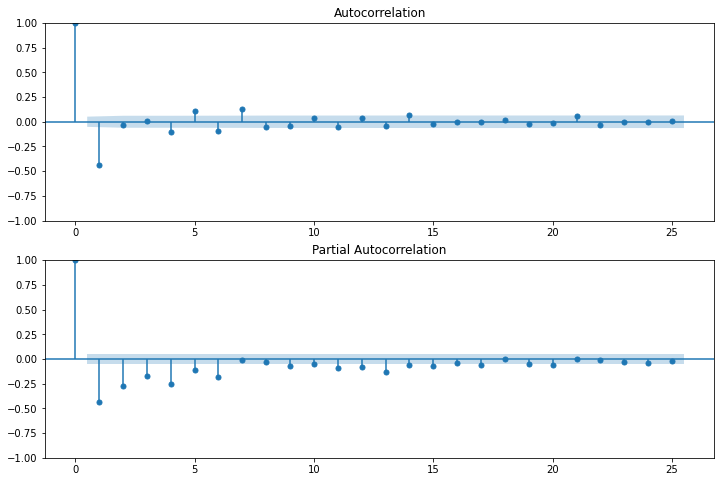

In [40]:
# 5. Определите порядок модели AR по графику частичной автокорреляции.

from matplotlib import pyplot as plt
%matplotlib inline 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_diff1.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_diff1, lags=25, ax=ax2)

Выбираем p=6

In [41]:
# 7. Постройте модель AR и предскажите последнее значение ряда.

p=6

ar_model = AutoReg(train, lags=p).fit()
print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train), end=(len(train)), dynamic=False)
ar_pred

                            AutoReg Model Results                             
Dep. Variable:                    qty   No. Observations:                 1438
Model:                     AutoReg(6)   Log Likelihood              -18221.056
Method:               Conditional MLE   S.D. of innovations          81248.064
Date:                Wed, 01 Mar 2023   AIC                          36458.111
Time:                        00:28:04   BIC                          36500.246
Sample:                    12-31-2009   HQIC                         36473.844
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.047e+04   6160.175      4.946      0.000    1.84e+04    4.25e+04
qty.L1         0.3074      0.026     11.654      0.000       0.256       0.359
qty.L2         0.1582      0.027      5.835      0.0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2013-12-02    318174.284553
Freq: D, dtype: float64

In [46]:
# 8. Сравните полученные результаты.
from sklearn.metrics import mean_squared_error

mean_squared_error(test, ar_pred), mean_squared_error(test, forecast)

(11166511445.47285, 39533558724.37031)